##Ejemplo de regresión con PyTorch

Basado en notebook de https://github.com/Lightning-AI

%pip install torch
%pip install watermark
conda update --all

Si cuando corren la celda de matplotlib (la que grafica la relación feature-target) les crashea el kernel,
deberían eliminar el duplicado de libiomp5md.dll, que está en anaconda3/lib donde se instaló torch.



In [10]:
%pip install torchvision

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.2 MB 2.8 MB/s eta 0:00:01
     -------------- ------------------------- 0.4/1.2 MB 4.4 MB/s eta 0:00:01
     ----------------------------------- ---- 1.1/1.2 MB 8.4 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext watermark
%watermark -v -p torch,matplotlib --conda

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

torch     : 2.0.1
matplotlib: 3.7.2

conda environment: base



## Dataset

In [3]:
import torch

X_train = torch.tensor(
    [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]
).view(-1, 1)

y_train = torch.tensor(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
)

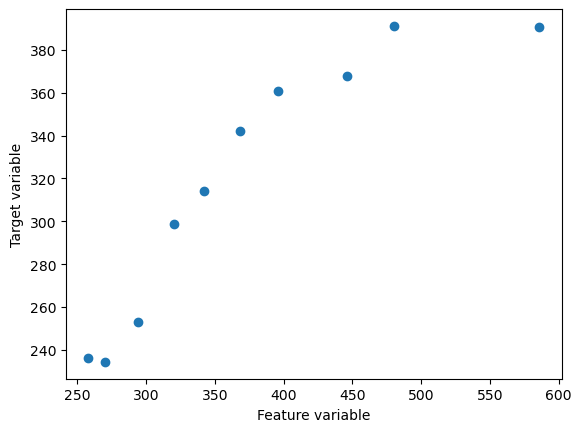

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train)
plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.show()

## Multilayer Perceptron

- No architecture changes besides the output unit

In [4]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, 1), ## Only 1 output unit
        )

    def forward(self, x):
        logits = self.all_layers(x).flatten()
        return logits

#### Normalize data

In [5]:
x_mean, x_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train_norm = (X_train - x_mean) / x_std
y_train_norm = (y_train - y_mean) / y_std

#### Set up DataLoader

In [6]:
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = X
        self.targets = y

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return self.targets.shape[0]


train_ds = MyDataset(X_train_norm, y_train_norm)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=20,
    shuffle=True,
)

### Train Model

In [7]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 30

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        logits = model(features)
        loss = F.mse_loss(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

Epoch: 001/030 | Batch 000/001 | Train Loss: 0.86
Epoch: 002/030 | Batch 000/001 | Train Loss: 0.63
Epoch: 003/030 | Batch 000/001 | Train Loss: 0.45
Epoch: 004/030 | Batch 000/001 | Train Loss: 0.29
Epoch: 005/030 | Batch 000/001 | Train Loss: 0.18
Epoch: 006/030 | Batch 000/001 | Train Loss: 0.11
Epoch: 007/030 | Batch 000/001 | Train Loss: 0.08
Epoch: 008/030 | Batch 000/001 | Train Loss: 0.07
Epoch: 009/030 | Batch 000/001 | Train Loss: 0.06
Epoch: 010/030 | Batch 000/001 | Train Loss: 0.05
Epoch: 011/030 | Batch 000/001 | Train Loss: 0.05
Epoch: 012/030 | Batch 000/001 | Train Loss: 0.04
Epoch: 013/030 | Batch 000/001 | Train Loss: 0.04
Epoch: 014/030 | Batch 000/001 | Train Loss: 0.04
Epoch: 015/030 | Batch 000/001 | Train Loss: 0.03
Epoch: 016/030 | Batch 000/001 | Train Loss: 0.03
Epoch: 017/030 | Batch 000/001 | Train Loss: 0.03
Epoch: 018/030 | Batch 000/001 | Train Loss: 0.02
Epoch: 019/030 | Batch 000/001 | Train Loss: 0.02
Epoch: 020/030 | Batch 000/001 | Train Loss: 0.02


### Normalize "new" data

In [8]:
model.eval()

X_range = torch.arange(150, 800, 0.1).view(-1, 1)
X_range_norm = (X_range - x_mean) / x_std

# predict
with torch.no_grad():
    y_mlp_norm = model(X_range_norm)

# MLP returns normalized predictions
# undo normalization of preditions for plotting
y_mlp = y_mlp_norm * y_std + y_mean

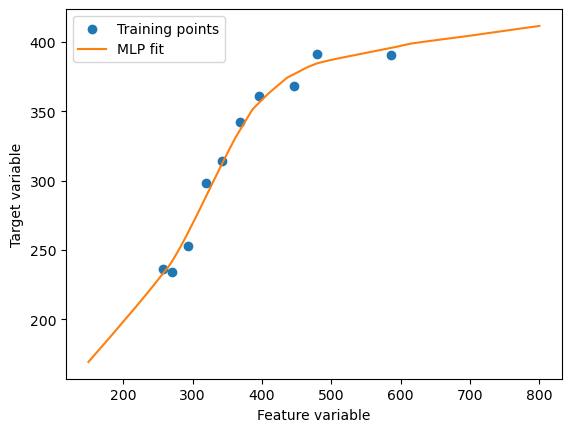

In [9]:
# plot results
plt.scatter(X_train, y_train, label="Training points")
plt.plot(X_range, y_mlp, color="C1", label="MLP fit", linestyle="-")


plt.xlabel("Feature variable")
plt.ylabel("Target variable")
plt.legend()
# plt.savefig("mlp.pdf")
plt.show()